# Процесс анализа выборки, меньшей по объему данных для обеспечения большей производительности алгоритмов классификации

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

### Загрузка входных данных

In [2]:
df_drop = pd.read_csv('D:\ВКР\проект\df_drop.csv')

In [3]:
df_nlp = pd.read_csv(r'D:\ВКР\проект\df_nlp.csv')

### Предобработка данных

In [4]:
df_nlp['OKPD_NUM']  = df_nlp['OKPD_NUM'].astype('string')

In [5]:
def get_group(value):    
    if value in ('41.2', '43.1', '43.3', '43.9'):  
        return 'Строительно-монтажные работы'
    elif value in ('41.1', '71.1'):  
        return 'Проектно-изыскательские работы'
    elif value in ('43.2', '42.2'):  
        return 'Подключение коммуникаций'
    else:
        return 'Прочие'

In [6]:
df_nlp['GROUP'] = df_nlp['OKPD_NUM'].apply(lambda x: get_group(x))
df_nlp.head()

,OBJECT_NAME,OKPD_NUM,CLEAN_OBJECT_NAME,STEM_OBJECT_NAME,GROUP
0,Поставка металлической мебели,31.0,поставка металлической мебели,"['поставк', 'металлическ', 'мебел']",Прочие
1,поставка офисных кресел,31.0,поставка офисных кресел,"['поставк', 'офисн', 'кресел']",Прочие
2,прочая закупка услуг (услуги по монтажу и пуск...,43.2,прочая закупка услуг услуги по монтажу и пуск...,"['проч', 'закупк', 'услуг', 'услуг', 'монтаж',...",Подключение коммуникаций
3,прочая закупка товара (стулья ученические),31.0,прочая закупка товара стулья ученические,"['проч', 'закупк', 'товар', 'стул', 'ученическ']",Прочие
4,выполнение работ по текущему ремонту заполнени...,43.3,выполнение работ по текущему ремонту заполнени...,"['выполнен', 'работ', 'текущ', 'ремонт', 'запо...",Строительно-монтажные работы


df_work_chunk = df_work.iloc[:5000,:]

### Выделение части датасета трех классов в произвольном порядке

In [7]:
group_1 = df_nlp[df_nlp['GROUP'] == 'Подключение коммуникаций'].sample(5500)

In [9]:
group_1.head()

,OBJECT_NAME,OKPD_NUM,CLEAN_OBJECT_NAME,STEM_OBJECT_NAME,GROUP
556154,оказание услуг по полному техническому обслужи...,43.2,оказание услуг по полному техническому обслужи...,"['оказан', 'услуг', 'полн', 'техническ', 'обсл...",Подключение коммуникаций
193216,Строительство светофорного объекта на перекрес...,43.2,строительство светофорного объекта на перекрес...,"['строительств', 'светофорн', 'объект', 'перек...",Подключение коммуникаций
654206,Испытание наружной пожарной лестницы,43.2,испытание наружной пожарной лестницы,"['испытан', 'наружн', 'пожарн', 'лестниц']",Подключение коммуникаций
385117,Выполнение работ по огнезащитной обработке дер...,43.2,выполнение работ по огнезащитной обработке дер...,"['выполнен', 'работ', 'огнезащитн', 'обработк'...",Подключение коммуникаций
605621,Капитальный ремонт теплотрассы от колодца ул. ...,43.2,капитальный ремонт теплотрассы от колодца ул ...,"['капитальн', 'ремонт', 'теплотрасс', 'колодц'...",Подключение коммуникаций


In [10]:
group_2 = df_nlp[df_nlp['GROUP'] == 'Строительно-монтажные работы'].sample(5500)

In [11]:
group_3 = df_nlp[df_nlp['GROUP'] == 'Прочие'].sample(5500)

### Загрузка методов и функций - инструментов для NLP

In [12]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from nltk.stem.snowball import SnowballStemmer

In [13]:
STOPWORDS = set(stopwords.words('russian'))

In [14]:
def clean_text(text):
    """
    Функция для вычистки данных от латинских символов, цифр и перевода текста в нижний регистр
    """
    text = str(text).lower()  
    text = re.sub(r'[a-zA-Z0-9]', '', text)
    text = re.sub(r'[^\w\s]|_', ' ', text)
    return text

In [15]:
def stemming(column, stopwords=STOPWORDS):
    stemmer = SnowballStemmer("russian")
    tokens_stem = [stemmer.stem(word) for word in word_tokenize(column) if not word in stopwords]
    return tokens_stem

In [16]:
def clean_column(df):
    """
    Обработка целевого столбца 
    """
    df['CLEAN_OBJECT_NAME'] = df['OBJECT_NAME'].apply(clean_text)
    df['STEM_OBJECT_NAME'] = df['CLEAN_OBJECT_NAME'].apply(
        lambda x: stemming(x, stopwords=STOPWORDS))
    return df

### Выделение и предобработка отдельных классов "Строительный надзор" и "Проектно-изыскательские работы"

In [17]:
inspections = df_drop[df_drop['OBJECT_NAME'].str.contains(r'строительного контроля')]

In [21]:
inspections.head()

,ID,CONTRACT_NUM,OBJECT_NAME,COST,DESCR,OKPD_NUM,CLEAN_OBJECT_NAME,STEM_OBJECT_NAME
23715,31429,1662101488921000006,оказание услуг по осуществлению функций технич...,36694348.29,Услуги в области архитектуры и инженерно-техни...,71.1,оказание услуг по осуществлению функций технич...,"[оказан, услуг, осуществлен, функц, техническ,..."
32486,43765,1771454974421000088,Оказание услуг по осуществлению строительного ...,17000000.00,Услуги в области архитектуры и инженерно-техни...,71.1,оказание услуг по осуществлению строительного ...,"[оказан, услуг, осуществлен, строительн, контр..."
32487,43766,1771454974421000088,Оказание услуг по осуществлению строительного ...,17000000.00,Услуги в области архитектуры и инженерно-техни...,71.1,оказание услуг по осуществлению строительного ...,"[оказан, услуг, осуществлен, строительн, контр..."
32492,43771,1771454974421000091,Оказание услуг по осуществлению строительного ...,18000000.00,Услуги в области архитектуры и инженерно-техни...,71.1,оказание услуг по осуществлению строительного ...,"[оказан, услуг, осуществлен, строительн, контр..."
32493,43772,1771454974421000091,Оказание услуг по осуществлению строительного ...,18000000.00,Услуги в области архитектуры и инженерно-техни...,71.1,оказание услуг по осуществлению строительного ...,"[оказан, услуг, осуществлен, строительн, контр..."


In [20]:
group_4 = clean_column(inspections)
group_4.head()

,ID,CONTRACT_NUM,OBJECT_NAME,COST,DESCR,OKPD_NUM,CLEAN_OBJECT_NAME,STEM_OBJECT_NAME
23715,31429,1662101488921000006,оказание услуг по осуществлению функций технич...,36694348.29,Услуги в области архитектуры и инженерно-техни...,71.1,оказание услуг по осуществлению функций технич...,"[оказан, услуг, осуществлен, функц, техническ,..."
32486,43765,1771454974421000088,Оказание услуг по осуществлению строительного ...,17000000.00,Услуги в области архитектуры и инженерно-техни...,71.1,оказание услуг по осуществлению строительного ...,"[оказан, услуг, осуществлен, строительн, контр..."
32487,43766,1771454974421000088,Оказание услуг по осуществлению строительного ...,17000000.00,Услуги в области архитектуры и инженерно-техни...,71.1,оказание услуг по осуществлению строительного ...,"[оказан, услуг, осуществлен, строительн, контр..."
32492,43771,1771454974421000091,Оказание услуг по осуществлению строительного ...,18000000.00,Услуги в области архитектуры и инженерно-техни...,71.1,оказание услуг по осуществлению строительного ...,"[оказан, услуг, осуществлен, строительн, контр..."
32493,43772,1771454974421000091,Оказание услуг по осуществлению строительного ...,18000000.00,Услуги в области архитектуры и инженерно-техни...,71.1,оказание услуг по осуществлению строительного ...,"[оказан, услуг, осуществлен, строительн, контр..."


In [22]:
group_4 = group_4.drop(['ID', 'CONTRACT_NUM', 'COST', 'DESCR'], axis=1)

In [23]:
group_4['GROUP'] = 'Строительный надзор'

In [24]:
group_4.head()

,OBJECT_NAME,OKPD_NUM,CLEAN_OBJECT_NAME,STEM_OBJECT_NAME,GROUP
23715,оказание услуг по осуществлению функций технич...,71.1,оказание услуг по осуществлению функций технич...,"[оказан, услуг, осуществлен, функц, техническ,...",Строительный надзор
32486,Оказание услуг по осуществлению строительного ...,71.1,оказание услуг по осуществлению строительного ...,"[оказан, услуг, осуществлен, строительн, контр...",Строительный надзор
32487,Оказание услуг по осуществлению строительного ...,71.1,оказание услуг по осуществлению строительного ...,"[оказан, услуг, осуществлен, строительн, контр...",Строительный надзор
32492,Оказание услуг по осуществлению строительного ...,71.1,оказание услуг по осуществлению строительного ...,"[оказан, услуг, осуществлен, строительн, контр...",Строительный надзор
32493,Оказание услуг по осуществлению строительного ...,71.1,оказание услуг по осуществлению строительного ...,"[оказан, услуг, осуществлен, строительн, контр...",Строительный надзор


In [25]:
group_5_all = df_nlp[df_nlp['GROUP'] == 'Проектно-изыскательские работы']

In [27]:
group_5_all.head()

,OBJECT_NAME,OKPD_NUM,CLEAN_OBJECT_NAME,STEM_OBJECT_NAME,GROUP
33,Выполнение кадастровых работ и постановку на к...,71.1,выполнение кадастровых работ и постановку на к...,"['выполнен', 'кадастров', 'работ', 'постановк'...",Проектно-изыскательские работы
58,Выполнение работ по разработке проектно-сметны...,71.1,выполнение работ по разработке проектно сметны...,"['выполнен', 'работ', 'разработк', 'проектн', ...",Проектно-изыскательские работы
60,Изготовление технического паспорта и техническ...,71.1,изготовление технического паспорта и техническ...,"['изготовлен', 'техническ', 'паспорт', 'технич...",Проектно-изыскательские работы
67,Выполнение проектно-сметных работ по монтажу О...,71.1,выполнение проектно сметных работ по монтажу о...,"['выполнен', 'проектн', 'сметн', 'работ', 'мон...",Проектно-изыскательские работы
69,Оказание услуг по метрологической поверке приб...,71.1,оказание услуг по метрологической поверке приб...,"['оказан', 'услуг', 'метрологическ', 'поверк',...",Проектно-изыскательские работы


In [28]:
df_all = group_5_all.merge(group_4, on=['OBJECT_NAME'],
                   how='left', indicator=True)

In [29]:
df_all.head()

,OBJECT_NAME,OKPD_NUM_x,CLEAN_OBJECT_NAME_x,STEM_OBJECT_NAME_x,GROUP_x,OKPD_NUM_y,CLEAN_OBJECT_NAME_y,STEM_OBJECT_NAME_y,GROUP_y,_merge
0,Выполнение кадастровых работ и постановку на к...,71.1,выполнение кадастровых работ и постановку на к...,"['выполнен', 'кадастров', 'работ', 'постановк'...",Проектно-изыскательские работы,NaN,NaN,NaN,NaN,left_only
1,Выполнение работ по разработке проектно-сметны...,71.1,выполнение работ по разработке проектно сметны...,"['выполнен', 'работ', 'разработк', 'проектн', ...",Проектно-изыскательские работы,NaN,NaN,NaN,NaN,left_only
2,Изготовление технического паспорта и техническ...,71.1,изготовление технического паспорта и техническ...,"['изготовлен', 'техническ', 'паспорт', 'технич...",Проектно-изыскательские работы,NaN,NaN,NaN,NaN,left_only
3,Выполнение проектно-сметных работ по монтажу О...,71.1,выполнение проектно сметных работ по монтажу о...,"['выполнен', 'проектн', 'сметн', 'работ', 'мон...",Проектно-изыскательские работы,NaN,NaN,NaN,NaN,left_only
4,Оказание услуг по метрологической поверке приб...,71.1,оказание услуг по метрологической поверке приб...,"['оказан', 'услуг', 'метрологическ', 'поверк',...",Проектно-изыскательские работы,NaN,NaN,NaN,NaN,left_only


In [30]:
group_5_clear = df_all[df_all['_merge'] == 'left_only']

In [31]:
group_5_clear = group_5_clear.drop(['OKPD_NUM_y', 'CLEAN_OBJECT_NAME_y', 'STEM_OBJECT_NAME_y', 'GROUP_y', '_merge'], axis=1)
                    

In [32]:
group_5_clear = group_5_clear.rename(columns={'OKPD_NUM_x': 'OKPD_NUM',
                                              'CLEAN_OBJECT_NAME_x': 'CLEAN_OBJECT_NAME',
                                              'STEM_OBJECT_NAME_x': 'STEM_OBJECT_NAME',
                                              'GROUP_x': 'GROUP'})

In [33]:
group_5 = group_5_clear.sample(5500)

In [34]:
group_5.head()

,OBJECT_NAME,OKPD_NUM,CLEAN_OBJECT_NAME,STEM_OBJECT_NAME,GROUP
46725,оказание услуг комплексного оформления террито...,71.1,оказание услуг комплексного оформления террито...,"['оказан', 'услуг', 'комплексн', 'оформлен', '...",Проектно-изыскательские работы
7710,Оказание услуг по комплексному техническому об...,71.1,оказание услуг по комплексному техническому об...,"['оказан', 'услуг', 'комплексн', 'техническ', ...",Проектно-изыскательские работы
79273,Поверка средств измерений и контроль техничес...,71.1,поверка средств измерений и контроль техничес...,"['поверк', 'средств', 'измерен', 'контрол', 'т...",Проектно-изыскательские работы
22270,Выполнение кадастровых работ (изготовление акт...,71.1,выполнение кадастровых работ изготовление акт...,"['выполнен', 'кадастров', 'работ', 'изготовлен...",Проектно-изыскательские работы
8459,Осуществление авторского надзора за выполнение...,71.1,осуществление авторского надзора за выполнение...,"['осуществлен', 'авторск', 'надзор', 'выполнен...",Проектно-изыскательские работы


In [35]:
group_5['OBJECT_NAME'].value_counts().to_dict()

{'Оказание услуг по предповерочной подготовке и государственной поверке весового оборудования': 14,
 'Услуги в области кадастровой деятельности': 13,
 'Оказание услуг по экспертизе проектной документации на проведение работ по геологическому изучению недр и разведке месторождений полезных ископаемых по видам полезных ископаемых': 12,
 'Совместный конкурс в электронной форме на оказание услуг по метрологическому обслуживанию медицинских изделий в 2020-2021 годах в медицинских организациях Департамента здравоохранения города Москвы (МО2020-2021)': 11,
 'Поверка средств измерений': 10,
 'Выполнение кадастровых работ': 9,
 'Выполнение работ по геологическому изучению недр': 9,
 'Оказание услуг по строительному контролю за строительством, реконструкцией, капитальным ремонтом или ремонтом автомобильных дорог общего пользования местного значения и искусственных сооружений на них': 8,
 'Разработка проектно-сметной документации': 7,
 'Оказание услуг по поверке средств измерений': 7,
 'Оказание 

In [36]:
group_list = [group_3, group_4, group_5]
groups = group_1.append(group_2)
for group in group_list:
    groups =  groups.append(group)
groups

,OBJECT_NAME,OKPD_NUM,CLEAN_OBJECT_NAME,STEM_OBJECT_NAME,GROUP
556154,оказание услуг по полному техническому обслужи...,43.2,оказание услуг по полному техническому обслужи...,"['оказан', 'услуг', 'полн', 'техническ', 'обсл...",Подключение коммуникаций
193216,Строительство светофорного объекта на перекрес...,43.2,строительство светофорного объекта на перекрес...,"['строительств', 'светофорн', 'объект', 'перек...",Подключение коммуникаций
654206,Испытание наружной пожарной лестницы,43.2,испытание наружной пожарной лестницы,"['испытан', 'наружн', 'пожарн', 'лестниц']",Подключение коммуникаций
385117,Выполнение работ по огнезащитной обработке дер...,43.2,выполнение работ по огнезащитной обработке дер...,"['выполнен', 'работ', 'огнезащитн', 'обработк'...",Подключение коммуникаций
605621,Капитальный ремонт теплотрассы от колодца ул. ...,43.2,капитальный ремонт теплотрассы от колодца ул ...,"['капитальн', 'ремонт', 'теплотрасс', 'колодц'...",Подключение коммуникаций
...,...,...,...,...,...
13521,Выполнение работ по разработке проектно-сметно...,71.1,выполнение работ по разработке проектно сметно...,"['выполнен', 'работ', 'разработк', 'проектн', ...",Проектно-изыскательские работы
24147,Выполнение исполнительной геодезической съемк...,71.1,выполнение исполнительной геодезической съемк...,"['выполнен', 'исполнительн', 'геодезическ', 'с...",Проектно-изыскательские работы
22852,"Выполнение инженерных изысканий, разработка пр...",71.1,выполнение инженерных изысканий разработка пр...,"['выполнен', 'инженерн', 'изыскан', 'разработк...",Проектно-изыскательские работы
46022,оказание услуг по изготовлению технических пас...,71.1,оказание услуг по изготовлению технических пас...,"['оказан', 'услуг', 'изготовлен', 'техническ',...",Проектно-изыскательские работы


In [6]:
groups.to_csv(r'D:\ВКР\проект\groups.csv')

### Классификация

In [37]:
groups.dtypes

OBJECT_NAME          object
OKPD_NUM             object
CLEAN_OBJECT_NAME    object
STEM_OBJECT_NAME     object
GROUP                object
dtype: object

In [38]:
groups['OBJECT_NAME']  = groups['OBJECT_NAME'].astype('string')
groups['STEM_OBJECT_NAME']  = groups['STEM_OBJECT_NAME'].astype('string')
groups['GROUP']  = groups['GROUP'].astype('string')

#### Импорт библиотек визуализации и машинного обучения scikit-learn

In [39]:
import numpy as np
import matplotlib.pyplot as plt

In [40]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(groups ['STEM_OBJECT_NAME'], groups ['GROUP'], test_size=0.3, random_state=42)

In [41]:
from sklearn.pipeline import Pipeline
# pipeline позволяет объединить в один блок трансформер и модель, что упрощает написание кода и улучшает его читаемость
from sklearn.feature_extraction.text import TfidfVectorizer
# TfidfVectorizer преобразует тексты в числовые вектора, отражающие важность использования каждого слова из некоторого набора слов (количество слов набора определяет размерность вектора) в каждом тексте
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
# набор метрик для оценки качества модели
from sklearn.model_selection import GridSearchCV
# модуль поиска по сетке параметров

In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#### Логистическая регрессия

In [43]:
logreg_ppl_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('logreg_clf', LogisticRegression())])

In [44]:
logreg_ppl_clf.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('logreg_clf', LogisticRegression())])

In [45]:
predicted_logreg_ppl = logreg_ppl_clf.predict(X_test)
print(metrics.classification_report(predicted_logreg_ppl, y_test))

                                precision    recall  f1-score   support

      Подключение коммуникаций       0.84      0.84      0.84      1644
Проектно-изыскательские работы       0.90      0.96      0.93      1531
                        Прочие       0.92      0.89      0.90      1722
  Строительно-монтажные работы       0.84      0.84      0.84      1658
           Строительный надзор       0.99      0.97      0.98      1761

                      accuracy                           0.90      8316
                     macro avg       0.90      0.90      0.90      8316
                  weighted avg       0.90      0.90      0.90      8316



In [46]:
metrics.accuracy_score(y_test, predicted_logreg_ppl)

0.8997113997113997

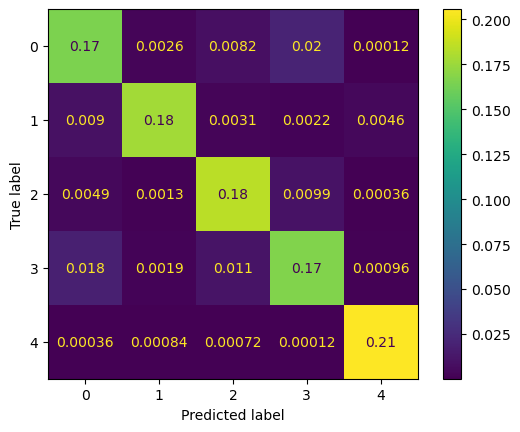

In [47]:
cm = confusion_matrix(y_test, predicted_logreg_ppl, normalize='all')

ConfusionMatrixDisplay(cm).plot()
plt.show()

#### Подбираем значения гиперпараметров для улучшения качества модели

In [48]:
grid = {
    'logreg_clf__C': np.logspace(-3, 3, 10),
    'logreg_clf__penalty': ['l1', 'l2']
}
grid

{'logreg_clf__C': array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
        4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
        2.15443469e+02, 1.00000000e+03]),
 'logreg_clf__penalty': ['l1', 'l2']}

In [49]:
from datetime import datetime
start_time = datetime.now()
search = GridSearchCV(logreg_ppl_clf, grid, cv=10)
search.fit(X_train, y_train)
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:02:18.209733


In [50]:
print('Best grid search hyperparameters are: '+str(search.best_params_))
print('Best grid search score is: '+str(search.best_score_))

Best grid search hyperparameters are: {'logreg_clf__C': 2.154434690031882, 'logreg_clf__penalty': 'l2'}
Best grid search score is: 0.9024376583438232


#### Случайный лес

In [51]:
from sklearn.ensemble import RandomForestClassifier

In [52]:
randfor_ppl_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('randfor_clf', RandomForestClassifier(n_jobs=-1))])

In [53]:
randfor_ppl_clf.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('randfor_clf', RandomForestClassifier(n_jobs=-1))])

In [54]:
predicted_randfor_ppl = randfor_ppl_clf.predict(X_test)
print(metrics.classification_report(predicted_randfor_ppl, y_test))

                                precision    recall  f1-score   support

      Подключение коммуникаций       0.83      0.83      0.83      1637
Проектно-изыскательские работы       0.91      0.95      0.93      1560
                        Прочие       0.91      0.89      0.90      1705
  Строительно-монтажные работы       0.83      0.83      0.83      1653
           Строительный надзор       1.00      0.98      0.99      1761

                      accuracy                           0.90      8316
                     macro avg       0.90      0.90      0.90      8316
                  weighted avg       0.90      0.90      0.90      8316



In [55]:
metrics.accuracy_score(y_test, predicted_randfor_ppl)

0.8971861471861472

Для грубой оценки подходящих гиперпараметров модели для начала воспользуемся RandomizedSearchCV

In [56]:
from sklearn.model_selection import RandomizedSearchCV

In [59]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
bootstrap = [True, False]
param_dist = {'randfor_clf__n_estimators': n_estimators,
               'randfor_clf__max_features': max_features,
               'randfor_clf__max_depth': max_depth,
               'randfor_clf__min_samples_split': min_samples_split,
               'randfor_clf__min_samples_leaf': min_samples_leaf,
               'randfor_clf__bootstrap': bootstrap}

In [60]:
from datetime import datetime
start_time = datetime.now()
rs = RandomizedSearchCV(randfor_ppl_clf, 
                            param_dist, 
                            n_iter = 50, 
                            cv = 3, 
                            verbose = 1, 
                            n_jobs=-1, 
                            random_state=0)
rs.fit(X_train, y_train)
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Duration: 0:01:20.080687


In [61]:
rs.best_params_

{'randfor_clf__n_estimators': 600,
 'randfor_clf__min_samples_split': 23,
 'randfor_clf__min_samples_leaf': 2,
 'randfor_clf__max_features': 'sqrt',
 'randfor_clf__max_depth': 15,
 'randfor_clf__bootstrap': False}

Для того чтобы выяснить, в каком диапазоне значений стоит продолжать поиск, выводим датафрейм, содержащий результаты работы алгоритма RandomizedSearchCV

In [62]:
rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'std_test_score'],
            axis=1)
rs_df.head(10)

,param_randfor_clf__n_estimators,param_randfor_clf__min_samples_split,param_randfor_clf__min_samples_leaf,param_randfor_clf__max_features,param_randfor_clf__max_depth,param_randfor_clf__bootstrap,mean_test_score,rank_test_score
0,600,23,2,sqrt,15,False,0.856259,1
1,400,23,2,sqrt,14,False,0.854095,2
2,700,12,2,sqrt,13,False,0.852600,3
3,1000,44,2,sqrt,9,True,0.845797,4
4,1000,34,23,sqrt,14,True,0.838736,5
5,400,23,12,sqrt,11,True,0.837293,6
6,600,50,2,sqrt,7,False,0.836314,7
7,500,39,18,sqrt,11,False,0.835953,8
8,700,23,12,sqrt,8,True,0.833582,9
9,800,34,28,sqrt,7,False,0.831675,10


Теперь создадим столбчатые графики, на которых, по оси Х, расположены значения гиперпараметров, а по оси Y — средние значения, показываемые моделями. Это позволит понять то, какие значения гиперпараметров, в среднем, лучше всего себя показывают

In [63]:
import seaborn as sns

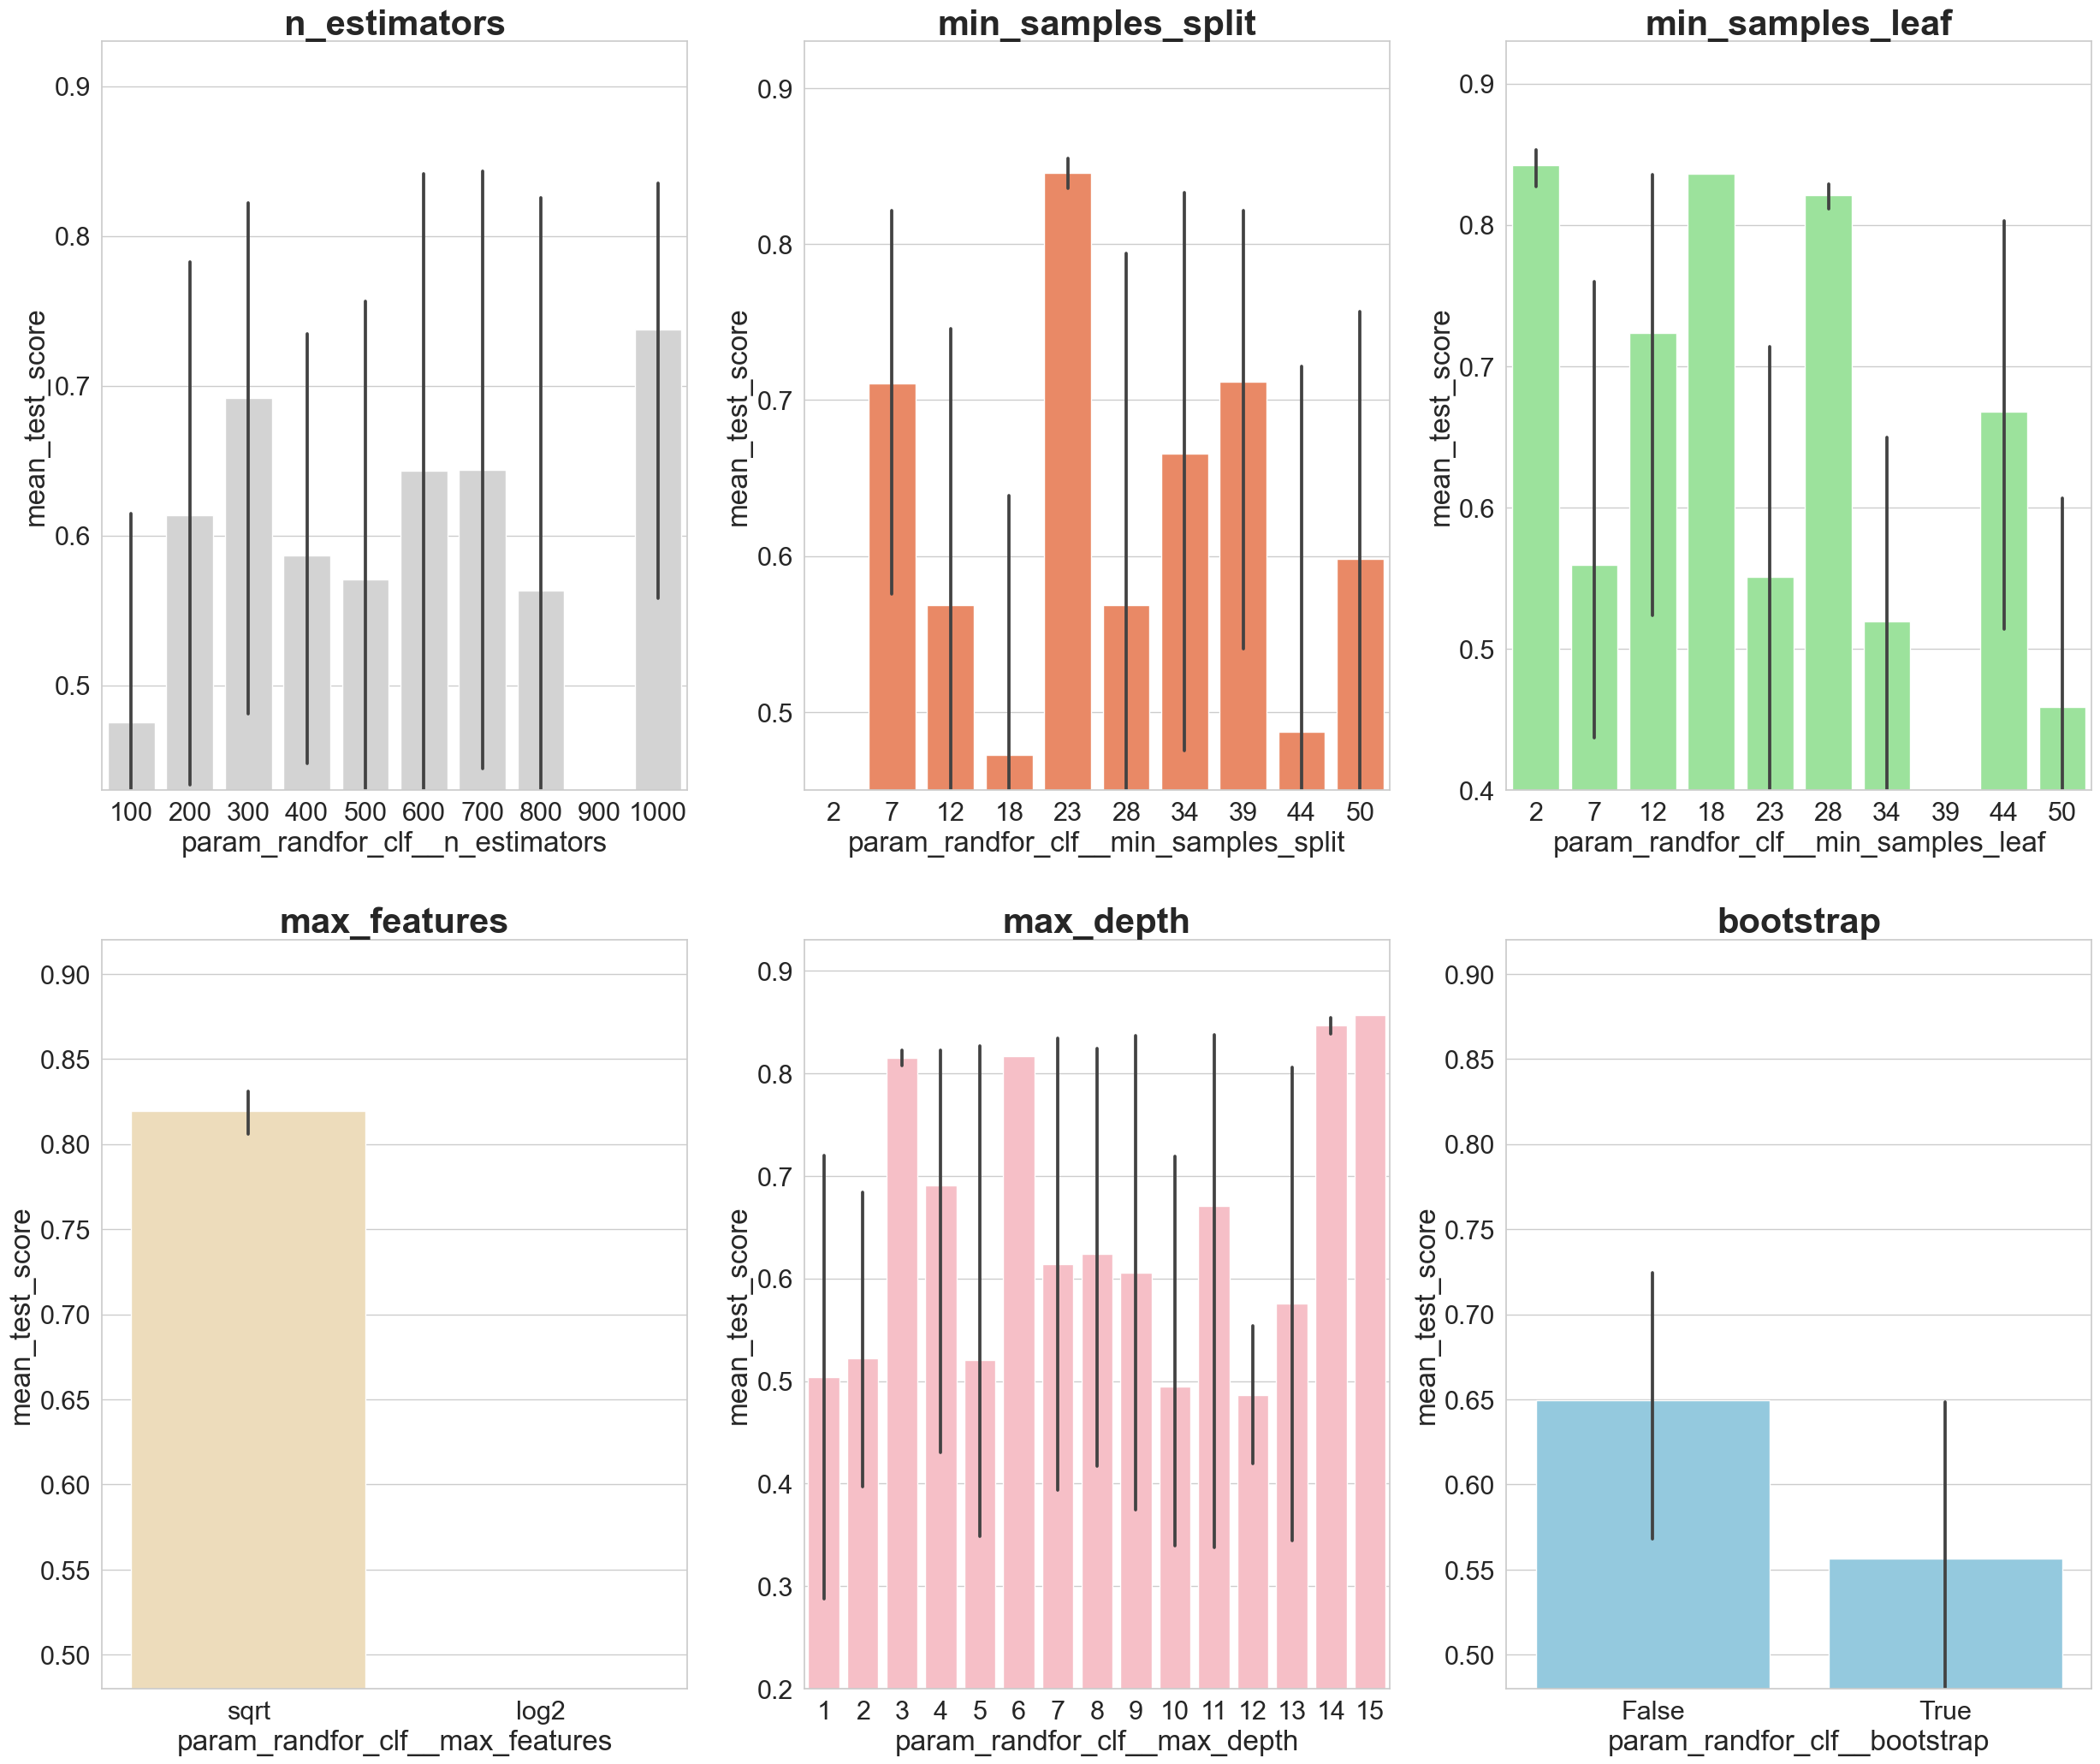

In [69]:
fig, axs = plt.subplots(ncols=3, nrows=2)
sns.set(style="whitegrid", color_codes=True, font_scale = 2)
fig.set_size_inches(30,25)
sns.barplot(x='param_randfor_clf__n_estimators', y='mean_test_score', data=rs_df, ax=axs[0,0], color='lightgrey')
axs[0,0].set_ylim([.43,.93])
axs[0,0].set_title(label = 'n_estimators', size=30, weight='bold')
sns.barplot(x='param_randfor_clf__min_samples_split', y='mean_test_score', data=rs_df, ax=axs[0,1], color='coral')
axs[0,1].set_ylim([.45,.93])
axs[0,1].set_title(label = 'min_samples_split', size=30, weight='bold')
sns.barplot(x='param_randfor_clf__min_samples_leaf', y='mean_test_score', data=rs_df, ax=axs[0,2], color='lightgreen')
axs[0,2].set_ylim([.40,.93])
axs[0,2].set_title(label = 'min_samples_leaf', size=30, weight='bold')
sns.barplot(x='param_randfor_clf__max_features', y='mean_test_score', data=rs_df, ax=axs[1,0], color='wheat')
axs[1,0].set_ylim([.48,.92])
axs[1,0].set_title(label = 'max_features', size=30, weight='bold')
sns.barplot(x='param_randfor_clf__max_depth', y='mean_test_score', data=rs_df, ax=axs[1,1], color='lightpink')
axs[1,1].set_ylim([.20,.93])
axs[1,1].set_title(label = 'max_depth', size=30, weight='bold')
sns.barplot(x='param_randfor_clf__bootstrap',y='mean_test_score', data=rs_df, ax=axs[1,2], color='skyblue')
axs[1,2].set_ylim([.48,.92])
axs[1,2].set_title(label = 'bootstrap', size=30, weight='bold')
plt.show()

Теперь на основании результатов RandomizedSearchCV проведем более точную настройку параметров для повышения точности модели

In [70]:
from sklearn.model_selection import GridSearchCV
n_estimators = [300, 600, 700, 1000]
max_features = ['sqrt']
max_depth = [3, 6, 14, 15]
min_samples_split = [7, 23, 34, 39]
min_samples_leaf = [12, 18, 28]
bootstrap = [False]
param_grid = {'randfor_clf__n_estimators': n_estimators,
               'randfor_clf__max_features': max_features,
               'randfor_clf__max_depth': max_depth,
               'randfor_clf__min_samples_split': min_samples_split,
               'randfor_clf__min_samples_leaf': min_samples_leaf,
               'randfor_clf__bootstrap': bootstrap}

In [71]:
from datetime import datetime
start_time = datetime.now()
gs = GridSearchCV(randfor_ppl_clf, 
                  param_grid, 
                  cv = 3, 
                  verbose = 1, 
                  n_jobs=-1)
gs.fit(X_train, y_train)
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Fitting 3 folds for each of 192 candidates, totalling 576 fits
Duration: 0:06:04.907175


In [72]:
print('Best grid search hyperparameters are: '+str(gs.best_params_))
print('Best grid search score is: '+str(gs.best_score_))

Best grid search hyperparameters are: {'randfor_clf__bootstrap': False, 'randfor_clf__max_depth': 15, 'randfor_clf__max_features': 'sqrt', 'randfor_clf__min_samples_leaf': 12, 'randfor_clf__min_samples_split': 39, 'randfor_clf__n_estimators': 700}
Best grid search score is: 0.8498168810799971


In [73]:
predicted_randfor_ppl_gs = gs.best_estimator_.predict(X_test)
print(metrics.classification_report(predicted_randfor_ppl_gs, y_test))

                                precision    recall  f1-score   support

      Подключение коммуникаций       0.73      0.79      0.76      1516
Проектно-изыскательские работы       0.83      0.94      0.88      1445
                        Прочие       0.86      0.82      0.84      1743
  Строительно-монтажные работы       0.80      0.75      0.78      1748
           Строительный надзор       1.00      0.93      0.96      1864

                      accuracy                           0.85      8316
                     macro avg       0.84      0.85      0.84      8316
                  weighted avg       0.85      0.85      0.85      8316



In [74]:
metrics.accuracy_score(y_test, predicted_randfor_ppl_gs)

0.8457190957190958